In [51]:
import pandas as pd
import numpy as np
import random
from collections import deque
# code https://github.com/pythonlessons
class CustomEnv:
    # A custom Bitcoin trading environment
    def __init__(self, df, initial_balance=1000, lookback_window_size=50):
        # Define action space and state size and other custom parameters
        self.df = df.dropna().reset_index()
        self.df_total_steps = len(self.df)-1
        self.initial_balance = initial_balance
        self.lookback_window_size = lookback_window_size

        # Action space from 0 to 3, 0 is hold, 1 is buy, 2 is sell
        self.action_space = np.array([0, 1, 2])

        # Orders history contains the balance, net_worth, crypto_bought, crypto_sold, crypto_held values for the last lookback_window_size steps
        self.orders_history = deque(maxlen=self.lookback_window_size)
        
        # Market history contains the OHCL values for the last lookback_window_size prices
        self.market_history = deque(maxlen=self.lookback_window_size)

        # State size contains Market+Orders history for the last lookback_window_size steps
        self.state_size = (self.lookback_window_size, 10)
        self.values = []

    # Reset the state of the environment to an initial state
    def reset(self, env_steps_size = 0):
        self.balance = self.initial_balance
        self.net_worth = self.initial_balance
        self.prev_net_worth = self.initial_balance
        self.crypto_held = 0
        self.crypto_sold = 0
        self.crypto_bought = 0
        if env_steps_size > 0: # used for training dataset
            self.start_step = random.randint(self.lookback_window_size, self.df_total_steps - env_steps_size)
            self.end_step = self.start_step + env_steps_size
        else: # used for testing dataset
            self.start_step = self.lookback_window_size
            self.end_step = self.df_total_steps
            
        self.current_step = self.start_step

        for i in reversed(range(self.lookback_window_size)):
            current_step = self.current_step - i
            self.orders_history.append([self.balance, self.net_worth, self.crypto_bought, self.crypto_sold, self.crypto_held])
            self.market_history.append(
                [self.df.loc[self.current_step, col] for col in cols]
            )

        state = np.concatenate((self.market_history, self.orders_history), axis=1)
        return state

    # Get the data points for the given current_step
    def _next_observation(self):
        self.market_history.append(
            [self.df.loc[self.current_step, col] for col in cols]
        )
        obs = np.concatenate((self.market_history, self.orders_history), axis=1)
        return obs

    # Execute one time step within the environment
    def step(self, action):
        self.crypto_bought = 0
        self.crypto_sold = 0
        self.current_step += 1

        # Set the current price to a random price between open and close
        current_price = random.uniform(
            self.df.loc[self.current_step, 'Open'],
            self.df.loc[self.current_step, 'Close'])
        
        if action == 0: # Hold
            pass
        
        elif action == 1 and self.balance > 0:
            # Buy with 100% of current balance
            self.crypto_bought = self.balance / current_price
            self.balance -= self.crypto_bought * current_price
            self.crypto_held += self.crypto_bought

        elif action == 2 and self.crypto_held>0:
            # Sell 100% of current crypto held
            self.crypto_sold = self.crypto_held
            self.balance += self.crypto_sold * current_price
            self.crypto_held -= self.crypto_sold

        self.prev_net_worth = self.net_worth
        self.net_worth = self.balance + self.crypto_held * current_price

        self.orders_history.append([self.balance, self.net_worth, self.crypto_bought, self.crypto_sold, self.crypto_held])

        # Calculate reward
        reward = self.net_worth - self.prev_net_worth

        if self.net_worth <= self.initial_balance/2:
            done = True
        else:
            done = False

        obs = self._next_observation()
        
        return obs, reward, done

    # render environment
    def render(self):
        self.values.append(self.net_worth)

        
def Random_games(env, train_episodes = 50, training_batch_size=500):
    average_net_worth = 0
    valueslists = []
    for episode in range(train_episodes):
        state = env.reset(env_steps_size = training_batch_size)

        while True:
            env.render()

            action = np.random.randint(3, size=1)[0]

            state, reward, done = env.step(action)

            if env.current_step == env.end_step:
                average_net_worth += env.net_worth
                print("net_worth:", env.net_worth)
                break
        valueslists.append(env.values)

    print("average_net_worth:", average_net_worth/train_episodes)
    return valueslists


### Data

In [31]:
d = pd.read_parquet("XRP_1MIN_WITH_INDICATORS.parquet")
d = d.rename({
    'Closing_price' : 'Close',
    'Opening_price' : 'Open',
    'Highest_price' : 'High',
    'Lowest_price' : 'Low',
    'Volume_of_transactions' : 'Volume',
}, axis = 1)
d = d.drop(['SQZMI'], axis = 1)    
cols = d.columns
trainsize = int(d.shape[0]*0.75)
lookback_window_size = 60
train_df = d[:-trainsize-lookback_window_size]
test_df = d[-trainsize-lookback_window_size:] 

### Training

In [42]:
train_env = CustomEnv(train_df, lookback_window_size=lookback_window_size)

rg = Random_games(train_env, train_episodes = 20, training_batch_size=500)

net_worth: 981.6707447358885
net_worth: 1002.3154010505522
net_worth: 983.7017057817092
net_worth: 988.0787435452701
net_worth: 1000.5708906747742
net_worth: 1003.7682958907486
net_worth: 1001.2474730676597
net_worth: 991.8210989595786
net_worth: 984.1175753326596
net_worth: 1003.123261839883
net_worth: 989.7814330669174
net_worth: 1018.0441327205258
net_worth: 984.2793941424558
net_worth: 1003.9307057580196
net_worth: 1005.1219960875275
net_worth: 1013.9864192072777
net_worth: 999.7433258091344
net_worth: 992.174249189025
net_worth: 998.3586664118242
net_worth: 983.6794398738749
average_net_worth: 996.4757476572652


### Results

In [20]:
import matplotlib.pyplot as plt

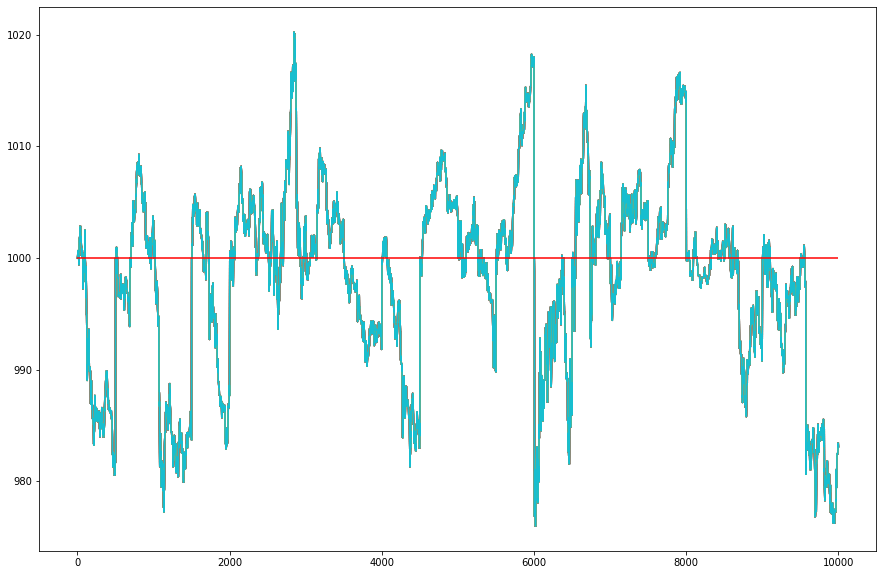

In [49]:
plt.figure( figsize = (15, 10))
for p in rg:
    plt.plot(p)
plt.hlines(1000, 0, len(p), colors = "red")